In [2]:
#########################################################################
# 1. Setup and Imports
#########################################################################

# --- Core utilities ---
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display

# --- Hugging Face libraries ---
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

# --- Metrics ---
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---Device & batch size---

if torch.cuda.is_available():
    device = "cuda"
    BATCH_SIZE = 16   # bigger batch on GPU
else:
    device = "cpu"
    BATCH_SIZE = 8    # smaller batch on CPU


print(f"✅ Device detected: {device}")
print(f"📦 Batch size per device: {BATCH_SIZE}")
print(f"🧠 PyTorch version: {torch.__version__}")

✅ Device detected: cpu
📦 Batch size per device: 8
🧠 PyTorch version: 2.8.0+cu126


In [3]:
#########################################################################
# 2. Load and Explore the Dataset
#########################################################################
train_df = pd.read_csv(
    "https://raw.githubusercontent.com/Abrhm-ma25/Text-classification-algorithm/refs/heads/main/Datasets/step1-2_cleaned_data.csv"
)
val_df = pd.read_csv(
    "https://raw.githubusercontent.com/Abrhm-ma25/Text-classification-algorithm/refs/heads/main/Datasets/step1-2_cleaned_validation.csv"
)

print(f"✅ Training data shape: {train_df.shape}")
print(f"✅ Validation data shape: {val_df.shape}")
print("Training sentiment distribution:")
print(train_df["sentiment"].value_counts())

# Remove previous column names

train_df = train_df.iloc[1:].reset_index(drop=True)
val_df = val_df.iloc[1:].reset_index(drop=True)

# Preview
print("\n🔹 Training set preview:")
display(train_df.head())

print("\n🔹 Validation set preview:")
display(val_df.head())

✅ Training data shape: (50371, 4)
✅ Validation data shape: (824, 4)
Training sentiment distribution:
sentiment
Positive    18548
Negative    16345
Neutral     15478
Name: count, dtype: int64

🔹 Training set preview:


,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...



🔹 Validation set preview:


,id,topic,sentiment,tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


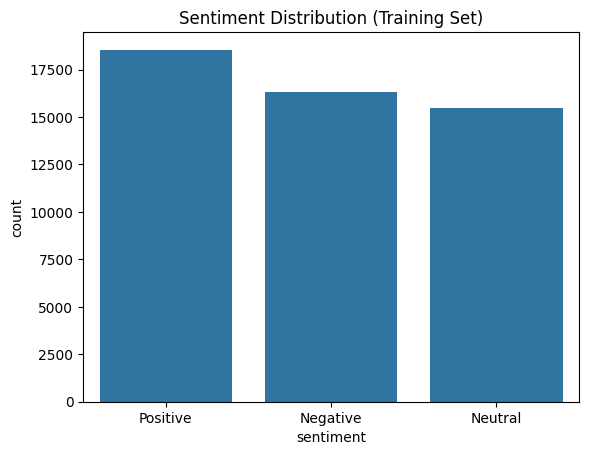

In [ ]:
# Check class distribution
sns.countplot(x="sentiment", data=train_df, order=train_df["sentiment"].value_counts().index)
plt.title("Sentiment Distribution (Training Set)")
plt.show()

In [ ]:
#########################################################################
# 3. Preprocessing
#########################################################################

# 1️⃣ Rename columns for consistency
train_df = train_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})
val_df   = val_df.rename(columns={"tweet": "text", "sentiment": "Sentiment"})

# 2️⃣ Map 3 sentiment classes to numeric labels
label_map = {label: i for i, label in enumerate(sorted(train_df["Sentiment"].unique()))}
train_df["label"] = train_df["Sentiment"].map(label_map)
val_df["label"]   = val_df["Sentiment"].map(label_map)

print("✅ Label mapping:", label_map)
print("✅ Sentiments present:", unique_labels)

train_df_model = train_df[["text", "label"]].reset_index(drop=True)
val_df_model   = val_df[["text", "label"]].reset_index(drop=True)

print("\nTrain (model) head:")
display(train_df_model.head())

print("\nVal (model) head:")
display(val_df_model.head())

# 3️⃣ Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df_model)
val_dataset   = Dataset.from_pandas(val_df_model)


✅ Label mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}
✅ Sentiments present: ['Positive' 'Neutral' 'Negative']


In [ ]:
# ============================================================
# 6. Utility: Freeze last N transformer layers (for encoder models)
# ============================================================

def freeze_transformer_layers(model, n_unfrozen: int = 2):
    """
    Freeze all base transformer layers except the last `n_unfrozen` encoder layers.
    Works for models that follow the `base_model_prefix` convention (e.g., roberta).
    """
    if not hasattr(model, "base_model_prefix"):
        print("⚠️ Model has no base_model_prefix. Skipping freezing.")
        return

    base = getattr(model, model.base_model_prefix, None)
    if base is None:
        print("⚠️ Could not access base model. Skipping freezing.")
        return

    encoder = getattr(base, "encoder", None)
    if encoder is None or not hasattr(encoder, "layer"):
        print("⚠️ Could not access encoder layers. Skipping freezing.")
        return

    # 1) Freeze all base parameters
    for param in base.parameters():
        param.requires_grad = False

    # 2) Unfreeze last n layers
    if n_unfrozen > 0:
        for layer in encoder.layer[-n_unfrozen:]:
            for param in layer.parameters():
                param.requires_grad = True

    # 3) Always train the classification head
    if hasattr(model, "classifier"):
        for param in model.classifier.parameters():
            param.requires_grad = True

    print(f"✅ Frozen all base layers except last {n_unfrozen} transformer layers.")


In [ ]:
# ============================================================
# 4. Fine-tuning: Encoder-only models (RoBERTa)
# ============================================================

def train_and_evaluate_encoder(model_name: str, num_train_epochs: int = 3):
    """
    Fine-tune encoder-only models (BERT, RoBERTa, DeBERTa...) on sentiment classification.
    Uses:
    - dynamic padding via DataCollatorWithPadding
    - early stopping
    - optional layer freezing
    """
    print(f"\n🚀 Fine-tuning (Encoder-only): {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # --- Tokenization ---
    def tokenize_fn(examples):
        texts = list(examples["text"])
        return tokenizer(
            texts,
            truncation=True,
            padding=False,  # padding handled by DataCollatorWithPadding
            max_length=128,
        )

    tokenized_train = train_dataset.map(tokenize_fn, batched=True)
    tokenized_val   = val_dataset.map(tokenize_fn, batched=True)

    # --- Model setup ---
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_map)
    ).to(device)

    # Freeze all but last 2 layers (RoBERTa) + classifier
    freeze_transformer_layers(model, n_unfrozen=2)

    # --- Metrics (accuracy, precision, recall, f1) ---
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average="weighted", zero_division=0
        )
        acc = accuracy_score(labels, preds)
        return {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    # --- Training arguments (note: eval_strategy, not evaluation_strategy) ---
    args = TrainingArguments(
        output_dir=f"./results/{model_name.split('/')[-1]}",
        eval_strategy="epoch",              # ✅ transformers 4.57
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
    )

    # --- Data collator for efficient padding ---
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # --- Trainer with Early Stopping ---
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()
    results = trainer.evaluate()
    return model, tokenizer, results


In [ ]:
# ============================================================
# 5. Fine-tuning: Encoder–Decoder models (T5-small)
# ============================================================

def train_and_evaluate_encoder_decoder(model_name: str, num_train_epochs: int = 3):
    """
    Fine-tune encoder-decoder models (T5, BART...) by framing sentiment as text generation.

    Input:  "tweet: <text> sentiment:"
    Target: "Positive" / "Negative" / "Neutral"
    """
    print(f"\n🚀 Fine-tuning (Encoder-Decoder): {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

    id2label = {v: k for k, v in label_map.items()}
    train_df_local = train_df.copy()
    val_df_local   = val_df.copy()

    train_df_local["target_text"] = train_df_local["label"].map(id2label)
    val_df_local["target_text"]   = val_df_local["label"].map(id2label)

    train_df_local["formatted_input"] = "tweet: " + train_df_local["text"] + " sentiment:"
    val_df_local["formatted_input"]   = "tweet: " + val_df_local["text"] + " sentiment:"

    train_dataset_t5 = Dataset.from_pandas(
        train_df_local[["formatted_input", "target_text"]]
    )
    val_dataset_t5 = Dataset.from_pandas(
        val_df_local[["formatted_input", "target_text"]]
    )

    def preprocess_fn(batch):
        model_inputs = tokenizer(
            batch["formatted_input"],
            padding="max_length",
            truncation=True,
            max_length=128,
        )
        # encode target labels
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                batch["target_text"],
                padding="max_length",
                truncation=True,
                max_length=10,
            )
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train = train_dataset_t5.map(preprocess_fn, batched=True)
    tokenized_val   = val_dataset_t5.map(preprocess_fn, batched=True)

    args = TrainingArguments(
        output_dir=f"./results/{model_name.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
    )

    trainer.train()

    # --- Simple accuracy evaluation on a sample of validation ---
    preds, refs = [], []
    sample_df = val_df_local.sample(min(300, len(val_df_local)), random_state=42)

    for _, row in sample_df.iterrows():
        prompt = "tweet: " + row["text"] + " sentiment:"
        input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.to(device)
        outputs = model.generate(input_ids, max_length=10)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        preds.append(pred)
        refs.append(row["target_text"])

    acc = accuracy_score(refs, preds)
    print(f"📏 T5-small sample accuracy on {len(sample_df)} examples: {acc:.4f}")

    return model, tokenizer, {"accuracy": acc}



🚀 Fine-tuning (Encoder-only): roberta-base


Map:   0%|          | 0/50370 [00:00<?, ? examples/s]

Map:   0%|          | 0/823 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.668000,0.513286,0.789793,0.792156,0.789793,0.788074
2,0.518700,0.370266,0.860267,0.860262,0.860267,0.860206
3,0.394400,0.305260,0.904010,0.907769,0.904010,0.904317
4,0.345800,0.283981,0.927096,0.927659,0.927096,0.927092


In [ ]:
# ============================================================
# 6. Run Experiments
# ============================================================

models_encoder = {
    "RoBERTa-base": "roberta-base"
}

models_encoder_decoder = {
    "T5-small": "t5-small"
}

results_dict = {}
NUM_EPOCHS = 3   # ✅ shorter training as you requested

# ---------- Encoder-only (RoBERTa) ----------
for name, model_name in models_encoder.items():
    start = time.time()
    model_enc, tokenizer_enc, results = train_and_evaluate_encoder(
        model_name,
        num_train_epochs=NUM_EPOCHS
    )
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)

# ---------- Encoder–Decoder (T5-small) ----------
for name, model_name in models_encoder_decoder.items():
    start = time.time()
    model_dec, tokenizer_dec, results = train_and_evaluate_encoder_decoder(
        model_name,
        num_train_epochs=NUM_EPOCHS
    )
    results["inference_time_sec"] = time.time() - start
    results_dict[name] = results
    print(f"\n{name} Results:", results)


In [ ]:
# ============================================================
# 7. Compare Model Performance
# ============================================================

results_df = pd.DataFrame(results_dict).T
display(results_df)

# Plot accuracy if present
if "accuracy" in results_df.columns:
    plt.figure(figsize=(6,4))
    sns.barplot(x=results_df.index, y=results_df["accuracy"])
    plt.title("Accuracy Comparison Across Models")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
else:
    print("No 'accuracy' field found in results_dict to plot.")


NameError: name 'results_dict' is not defined